In [68]:
from tensorflow.config import list_physical_devices
print(list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [1]:
import pandas as pd
import numpy as np
import time
from math import log
from sklearn.preprocessing import StandardScaler
from imutils import paths
import cv2
import matplotlib.pyplot as plt
from xml.dom import minidom
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.losses import CategoricalCrossentropy , mae,mse
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input  as vgg_pre
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow.keras.layers as tfl

In [2]:
faImgPath="./car_plate_fa/validation"
def getPersianPlates(end=500):
    for i,path in enumerate(paths.list_images(faImgPath)):
        if i <end:
            yield path


In [20]:
#USE THIS
# x=image_dataset_from_directory(directory=faImgPath,labels=None)
# sort images and labels in directory,then load images,and load labels seprately ,then test if these two matches

In [3]:
i=500
resized_width=400
resized_height=400
depth=3
n_y_features=4

In [4]:
def compute_ratio(org_width,org_height,resized_w,resized_h):
    return resized_w / org_width , resized_h / org_height

In [47]:
def custom_data_generator(img_directory,labels_directory, batch_size):
    file_list = os.listdir(img_directory)
    num_samples = len(file_list)
    num_batches = num_samples // batch_size    
    while True:
        # List all files in the data directory
        # Shuffle the file list for each epoch
        
        # np.random.shuffle(file_list)
        print("new epoch")
        
        for i in range(num_batches):
            batch_files = file_list[i * batch_size: (i + 1) * batch_size]
            batch_images = np.zeros((batch_size,resized_height,resized_width,depth))
            batch_labels = np.zeros((batch_size,n_y_features))
            
            for j,file_name in enumerate(batch_files):
                # Load and preprocess your data here
                image,w_ratio,h_ratio = load_and_preprocess_image(os.path.join(img_directory, file_name))
                label = load_and_preprocess_label(os.path.join(labels_directory,file_name.split(".")[0])
                                                  ,w_ratio,h_ratio)  
                
                batch_images[j]=image
                batch_labels[j]=label
            
            
            # Yield the batch data
            yield batch_images, batch_labels

In [26]:
def load_and_preprocess_image(file_path):
    img=cv2.imread(file_path)
    original_width=img.shape[1]
    original_height=img.shape[0]
    w_ratio,h_ratio=compute_ratio(original_width,original_height,resized_width,resized_height)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(resized_width,resized_height))
    img=img/255.0
    return img,w_ratio,h_ratio

In [27]:
def load_and_preprocess_label(label_path,w_ratio,h_ratio) :
    xmlPath=label_path+".xml"
    xmlFile=minidom.parse(xmlPath)
    xmin=int (float(xmlFile.getElementsByTagName("xmin")[0].firstChild.data)) 
    ymin=int (float(xmlFile.getElementsByTagName("ymin")[0].firstChild.data))
    xmax=int (float(xmlFile.getElementsByTagName("xmax")[0].firstChild.data)) 
    ymax=int (float(xmlFile.getElementsByTagName("ymax")[0].firstChild.data))
    xmin=int( xmin * w_ratio )
    ymin=int( ymin * h_ratio )
    xmax=int( xmax * w_ratio )
    ymax=int( ymax * h_ratio )
    return [xmin,ymin,xmax,ymax]
    

In [ ]:
from xml.dom import minidom

def load_and_preprocess_label(image_path, lbl_path, resized_width, resized_height):
    xmlPath = lbl_path + ".xml"
    xmlFile = minidom.parse(xmlPath)
    xmin = int(float(xmlFile.getElementsByTagName("xmin")[0].firstChild.data))
    ymin = int(float(xmlFile.getElementsByTagName("ymin")[0].firstChild.data))
    xmax = int(float(xmlFile.getElementsByTagName("xmax")[0].firstChild.data))
    ymax = int(float(xmlFile.getElementsByTagName("ymax")[0].firstChild.data))
    xmin = int(xmin * resized_width)
    ymin = int(ymin * resized_height)
    xmax = int(xmax * resized_width)
    ymax = int(ymax * resized_height)
    return [xmin, ymin, xmax, ymax]

def preprocess_image(image_path, lbl_path, resized_width, resized_height):
    image = tf.image.decode_jpeg(tf.io.read_file(image_path), channels=3)
    image = tf.image.resize(image, [resized_height, resized_width])
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.py_function(
        lambda image_path=image_path, lbl_path=lbl_path: load_and_preprocess_label(image_path, lbl_path, resized_width, resized_height),
        [], tf.int32
    )
    return image, label

def custom_data_generator(data_directory, labels_directory, batch_size, resized_width, resized_height):
    file_list = os.listdir(data_directory)

    def generator():
        for file_name in file_list:
            image_path = os.path.join(data_directory, file_name)
            lbl_path = os.path.join(labels_directory, file_name.split(".")[0])
            yield image_path, lbl_path

    dataset = tf.data.Dataset.from_generator(
        generator, output_signature=(
            tf.TensorSpec(shape=(), dtype=tf.string),
            tf.TensorSpec(shape=(), dtype=tf.string)
        ))

    dataset = dataset.map(
        lambda image_path, lbl_path: (
            image_path,
            lbl_path
        ),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    dataset = dataset.map(
        lambda image_path, lbl_path: preprocess_image(image_path, lbl_path, resized_width, resized_height),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    dataset = dataset.batch(batch_size)

    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

img_directory = "./car_plate_fa/validation"
lbl_directory = "./car_plate_fa/validation_labels"
batch_size = 2
resized_width = 150
resized_height = 150

train_generator = custom_data_generator(img_directory, lbl_directory, batch_size, resized_width, resized_height)

for batch_images, batch_labels in train_generator:
    print(batch_labels)


In [75]:
img_directory="./car_plate_fa/validation"
lbl_directory="./car_plate_fa/validation_labels"
batch_size=200
# steps_per_epoch = len(os.listdir(img_directory)) // batch_size
train_generator = custom_data_generator(img_directory, lbl_directory,batch_size)

In [5]:
# persian plates
X=np.zeros((i,resized_width,resized_height,depth))
y=np.zeros((i,4))

fig = plt.figure(figsize=(30, 30))
for carNumber, carPath in enumerate(getPersianPlates(end=i)):
    print("\r",carNumber,end="")
    img=cv2.imread(carPath)
    original_width=img.shape[1]
    original_height=img.shape[0]

    w_ratio,h_ratio=compute_ratio(original_width,original_height,resized_width,resized_height)

    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    xmlPath=faImgPath +"_labels" +"/" + carPath.split(os.path.sep)[-1].split(".")[0] +".xml"
    xmlFile=minidom.parse(xmlPath)
    xmin=int (xmlFile.getElementsByTagName("xmin")[0].firstChild.data) 
    ymin=int (xmlFile.getElementsByTagName("ymin")[0].firstChild.data) 
    xmax=int (xmlFile.getElementsByTagName("xmax")[0].firstChild.data) 
    ymax=int (xmlFile.getElementsByTagName("ymax")[0].firstChild.data)
    

    xmin=int( xmin * w_ratio )
    ymin=int( ymin * h_ratio )
    xmax=int( xmax * w_ratio )
    ymax=int( ymax * h_ratio )

    img=cv2.resize(img,(resized_width,resized_height)) 

    X[carNumber]=img
    y[carNumber][0]=xmin
    y[carNumber][1]=ymin
    y[carNumber][2]=xmax
    y[carNumber][3]=ymax
    # if carNumber%10==0:
    #     img_with_rect=cv2.rectangle(img,(xmin,ymin),(xmax,ymax),(0,0,255))
    #     cv2.imshow("win",cv2.resize(img_with_rect,(500,500)))
    #     cv2.waitKey(0)
    #     cv2.destroyAllWindows()
        
    
y=y.astype(np.int32)


 499

<Figure size 3000x3000 with 0 Axes>

In [11]:
#for foreign plates
# X=np.zeros((i,resized_width,resized_height,depth))
# y=np.zeros((i,4))

# fig = plt.figure(figsize=(30, 30))

# for carNumber in range(0,i):
#     img=cv2.imread(f"./carPlate/images/Cars{carNumber}.png")
#     img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     xmlFile=minidom.parse(f"./carPlate/annotations/Cars{carNumber}.xml")
#     xmin=int(xmlFile.getElementsByTagName("xmin")[0].firstChild.data)
#     ymin=int(xmlFile.getElementsByTagName("ymin")[0].firstChild.data)
#     xmax=int(xmlFile.getElementsByTagName("xmax")[0].firstChild.data)
#     ymax=int(xmlFile.getElementsByTagName("ymax")[0].firstChild.data)
#     for y in range(ymin,ymax):
#         for x in range(xmin,xmax):
#             img[y][x]=[255,255,255]
   
#     img=cv2.resize(img,(resized_width,resized_height))
    
#     X[carNumber]=img
#     y[carNumber][0]=xmin
#     y[carNumber][1]=ymin
#     y[carNumber][2]=xmax
#     y[carNumber][3]=ymax
    #fig.add_subplot(15,20,carNumber+1)
    #plt.axis('off')
    #plt.imshow(img)
    
    

In [6]:
#list implementaion
X_train_normal, X_test_normal, y_train, y_test = train_test_split(X, y, test_size=0.10,shuffle=False)

In [9]:
d=X_train_normal[63].astype(np.uint8)
print(d)
cv2.imshow("win",d)
cv2.waitKey(0)
cv2.destroyAllWindows()

[[[  6   9  16]
  [  7  10  17]
  [ 10  13  20]
  ...
  [161 162 157]
  [163 164 159]
  [161 162 157]]

 [[  8  11  18]
  [  5   8  15]
  [ 10  13  20]
  ...
  [164 165 160]
  [164 165 160]
  [165 166 161]]

 [[  7  10  17]
  [  8  11  18]
  [ 11  14  21]
  ...
  [164 165 160]
  [167 168 163]
  [168 169 164]]

 ...

 [[113 110 107]
  [113 110 106]
  [115 112 108]
  ...
  [152 144 131]
  [145 138 123]
  [145 136 130]]

 [[117 114 109]
  [124 125 120]
  [119 115 112]
  ...
  [142 135 119]
  [131 124 107]
  [128 118 116]]

 [[122 114 112]
  [119 121 116]
  [124 121 118]
  ...
  [154 147 128]
  [137 130 114]
  [142 132 133]]]


In [10]:
%run common.ipynb

In [34]:
model=plate_boundary_model(resized_height,resized_width)

In [35]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 400, 400, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 400, 400, 3)      0         
 bda)                                                            
                                                                 
 inception_resnet_v2 (Functi  (None, 11, 11, 1536)     54336736  
 onal)                                                           
                                                                 
 flatten_4 (Flatten)         (None, 185856)            0         
                                                           

In [36]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=mse,
              metrics=['accuracy'])

In [37]:
history = model.fit(X_train_normal,y_train,
                    # validation_data=val_dataset,
                    epochs=100
                    )

Epoch 1/100
15/15 [==============================] - 17s 494ms/step - loss: 16702.6660 - accuracy: 0.7422
Epoch 2/100
15/15 [==============================] - 8s 499ms/step - loss: 10117.2275 - accuracy: 0.8267
Epoch 3/100
15/15 [==============================] - 8s 497ms/step - loss: 9068.8594 - accuracy: 0.9044
Epoch 4/100
15/15 [==============================] - 8s 499ms/step - loss: 8640.0371 - accuracy: 0.9356
Epoch 5/100
15/15 [==============================] - 7s 496ms/step - loss: 8478.6182 - accuracy: 0.9578
Epoch 6/100
15/15 [==============================] - 8s 510ms/step - loss: 8348.7803 - accuracy: 0.9511
Epoch 7/100
15/15 [==============================] - 8s 515ms/step - loss: 8282.1299 - accuracy: 0.9578
Epoch 8/100
15/15 [==============================] - 8s 523ms/step - loss: 8189.2031 - accuracy: 0.9556
Epoch 9/100
15/15 [==============================] - 8s 519ms/step - loss: 8175.3188 - accuracy: 0.9444
Epoch 10/100
15/15 [==============================] - 8s 518m

KeyboardInterrupt: 

In [16]:
scaler=tf.keras.applications.inception_resnet_v2.preprocess_input
X_train=scaler(X_train_normal.copy())
X_test=scaler(X_test_normal.copy())

In [13]:
#reshape for not conv nn
#X=X.reshape((i,-1))
#----
#X=X.astype('float') /255.0

#standard scalar needs flatten data:
#normalizer_model=StandardScaler()
#normalizer_model.fit(X)
#X=normalizer_model.transform(X)
#---



In [32]:
model=MyVgg.build(resized_width,resized_height,depth,4)

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=mse,
             metrics=["accuracy"])

In [199]:
save_path="car_plate_weights/result.hdf5"

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 11, 11, 1536)     54336736  
 onal)                                                           
                                                                 
 flatten_2 (Flatten)         (None, 185856)            0         
                                                                 
 dense_8 (Dense)             (None, 256)               47579392  
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 4)                 260       
                                                      

In [19]:
img_directory="./car_plate_fa/validation"
lbl_directory="./car_plate_fa/validation_labels"
batch_size=32
steps_per_epoch = len(os.listdir(img_directory)) // batch_size
train_generator = custom_data_generator(img_directory, lbl_directory,batch_size)

In [13]:
#generator implementaion
steps_per_epoch = len(os.listdir(img_directory)) // batch_size

# checkpoint = ModelCheckpoint(save_path, monitor="val_accuracy",
# 	save_best_only=True, verbose=1)
# callbacks = [checkpoint]

model.fit(train_generator,epochs=500,
#           callbacks=callbacks,
          steps_per_epoch=steps_per_epoch
         )

Epoch 1/500
  5/132 [>.............................] - ETA: 9:59 - loss: 35681.7383 - accuracy: 0.5625 

KeyboardInterrupt: 

In [21]:
X_train.shape

(50, 400, 400, 3)

In [33]:
#list implementation
# checkpoint = ModelCheckpoint(save_path, monitor="loss",
# 	save_best_only=True, verbose=1)

# callbacks = [checkpoint]
history=model.fit(X_train,y_train,epochs=100
          #, callbacks=callbacks
          # ,validation_data=(X_test, y_test)
          ,batch_size=32,
         )

Epoch 1/100
15/15 [==============================] - 17s 526ms/step - loss: 11938.4385 - accuracy: 0.6800
Epoch 2/100
15/15 [==============================] - 7s 497ms/step - loss: 3101.0742 - accuracy: 0.8244
Epoch 3/100
15/15 [==============================] - 7s 492ms/step - loss: 1734.6066 - accuracy: 0.9022
Epoch 4/100
15/15 [==============================] - 7s 493ms/step - loss: 1098.4855 - accuracy: 0.9089
Epoch 5/100
15/15 [==============================] - 7s 493ms/step - loss: 657.1427 - accuracy: 0.8956
Epoch 6/100
15/15 [==============================] - 7s 493ms/step - loss: 405.4112 - accuracy: 0.9533
Epoch 7/100
15/15 [==============================] - 7s 495ms/step - loss: 319.9462 - accuracy: 0.9133
Epoch 8/100
15/15 [==============================] - 7s 494ms/step - loss: 206.2666 - accuracy: 0.9644
Epoch 9/100
15/15 [==============================] - 7s 494ms/step - loss: 129.9858 - accuracy: 0.9689
Epoch 10/100
15/15 [==============================] - 7s 495ms/step

KeyboardInterrupt: 

In [142]:
load_path="car_plate_weights/"
load_name="result.hdf5"
model=tf.keras.models.load_model(load_path + load_name)


In [21]:
model.evaluate(X_train,y_train)

 8/15 [===============>..............] - ETA: 51s - loss: 10.8394 - accuracy: 0.9922

KeyboardInterrupt: 

In [40]:
def show_prediction(x,y):
    x=np.array([x])
    x_scaled=scaler(x.copy())
    xmin,ymin,xmax,ymax=model.predict(x_scaled)[0].astype(np.int32)
    print(xmin,ymin,xmax,ymax)
    img=cv2.rectangle(x[0],(xmin,ymin),(xmax,ymax),(0,0,255))
    img=cv2.rectangle(img,(y[0],y[1]),(y[2],y[3]),(255,0,0))
    cv2.imshow("win",img.astype(np.uint8))
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [41]:
for i in range(1):
    input_array=X_train_normal #param
    index=np.random.randint(0,input_array.shape[0])
    index=0
    label=y_train[index].astype(np.int32) #param
    show_prediction(input_array[index],label)

1/1 [==============================] - 0s 69ms/step
201 109 236 116


In [207]:

fig2 = plt.figure(figsize=(30, 30))

j=360
#img2=cv2.imread(f"./carPlate/images/Cars{j}.png")
plateGenerator=list(getPersianPlates(end=1500))

testPath=plateGenerator[j]
img2=cv2.imread(testPath)
#img2=cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
original_width=img2.shape[1]
original_height=img2.shape[0]
img2=cv2.resize(img2,(resized_width,resized_height))


img3=img2.copy()


#img2=vgg_pre(img2)
img2=img2.astype("float")/255.0

img2=np.array([img2])

result=model.predict(img2)[0]
# result= result*265


<Figure size 3000x3000 with 0 Axes>

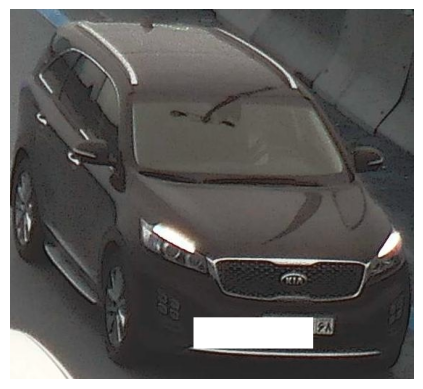

In [208]:
img2=cv2.imread(testPath)
#img2=cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
w_ratio,h_ratio=compute_ratio(original_width,original_height,resized_width,resized_height)
xmin=int(result[0] / w_ratio)
ymin=int(result[1] / h_ratio)
xmax=int(result[2] / w_ratio)
ymax=int(result[3] / h_ratio)
plate=[]
iteration=0
for y_ in range(ymin,ymax):
    plate.append([])
    for x_ in range(xmin,xmax):
        img2[y_][x_]=[255,255,255]
        #plate[iteration].append(img2[y][x])
    iteration=iteration+1
     
plt.axis('off')
plt.imshow(img2)
